In [1]:
import datetime
import inspect
import time

import matplotlib.pyplot as plt
import torch
import yaml
from hy2dl.modelzoo import get_model
from hy2dl.modelzoo.baseconceptualmodel import BaseConceptualModel
from hy2dl.utils.config import Config
from hy2dl.utils.utils import set_random_seed
from utilities.data import DataHandler
from utilities.postprocessing import Postprocessor
from utilities.training import Trainer

### Part 1. Setup

In [2]:
# Load configuration
config = yaml.safe_load(open("files/camels_gb.yml"))

# Modify configuration
config["experiment_name"] = "CAMELS-GB_Hybrid-Custom-Model_NSE"
config["path_save_folder"] = "results/run_Hybrid"
config["model"] = "hybrid"
config["conceptual_model"] = "shm"
config["dynamic_parameterization_conceptual_model"] = [
    "dd", "f_thr", "sumax", "beta", "perc", "kf", "ki", "kb"
]

# Convert into 'Config' object
config = Config(config)
config.dump()

### Part 2. Load data

In [3]:
# Get data
handler_data = DataHandler(config)
handler_data.load_data()

basin_ids = handler_data.get_basin_ids()

loader_training = handler_data.get_loader("training")
loader_validation = handler_data.get_loader("validation")
dataloaders = {
    "training": loader_training,
    "validation": loader_validation
}

2025-08-30 17:38:14 - Loading data from CAMELS_GB dataset...
2025-08-30 17:38:14 - Loading training data...


Processing entities: 100%|##########| 5/5 [00:00<00:00, 23.91entity/s]


2025-08-30 17:38:15 - Loading validation data...


Processing entities: 100%|##########| 3/3 [00:00<00:00, 31.76entity/s]


2025-08-30 17:38:15 - Basins without valid samples in period of interest: ['5003', '18014']
2025-08-30 17:38:15 - Number of valid samples
2025-08-30 17:38:15 -    Training:      25,573
2025-08-30 17:38:15 -    Validation:       792
2025-08-30 17:38:15 - Time required to process load data: 0:00:00
2025-08-30 17:38:15 - -------------------- Details DataLoader --------------------
2025-08-30 17:38:15 -              Key              |            Shape             
2025-08-30 17:38:23 - x_d
2025-08-30 17:38:23 -         precipitation         |    torch.Size([256, 730])    
2025-08-30 17:38:23 -              peti             |    torch.Size([256, 730])    
2025-08-30 17:38:23 -          temperature          |    torch.Size([256, 730])    
2025-08-30 17:38:23 - x_s                           |    torch.Size([256, 22])     
2025-08-30 17:38:23 - y_obs                         |  torch.Size([256, 365, 1])   
2025-08-30 17:38:23 - x_d_conceptual
2025-08-30 17:38:23 -         precipitation         

### Part 3. Model

In [4]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

In [5]:
# Check conceptual model parameter ranges and types
print(model.conceptual_model.parameter_ranges)
print(model.conceptual_model.parameter_type)

{'dd': (0.0, 10.0), 'f_thr': (10.0, 60.0), 'sumax': (20.0, 700.0), 'beta': (1.0, 6.0), 'perc': (0.0, 1.0), 'kf': (0.05, 0.9), 'ki': (0.01, 0.5), 'kb': (0.001, 0.2)}
{'dd': 'dynamic', 'f_thr': 'dynamic', 'sumax': 'dynamic', 'beta': 'dynamic', 'perc': 'dynamic', 'kf': 'dynamic', 'ki': 'dynamic', 'kb': 'dynamic'}


In [ ]:
class my_model(BaseConceptualModel):

    def __init__(self, cfg: Config):
        super(my_model, self).__init__()
        self.cfg = cfg
        self.n_conceptual_models = cfg.num_conceptual_models
        self.parameter_type = self._map_parameter_type(cfg=cfg)

    def forward(
        self,
        x_conceptual: dict[str, torch.Tensor],
        parameters: dict[str, torch.Tensor],
        initial_states: dict[str, torch.Tensor] | None = None,
    ) -> dict[str, torch.Tensor | dict[str, torch.Tensor]]:
        
        # initialize structures to store the information
        states, out = self._initialize_information(conceptual_inputs=x_conceptual)

        # initialize constants
        batch_size, seq_length = x_conceptual["precipitation"].shape
        device = x_conceptual["precipitation"].device

        if initial_states is None:  # if we did not specify initial states it takes the default values
            su = torch.full(
                (batch_size, self.n_conceptual_models),
                self._initial_states["su"],
                dtype=torch.float32,
                device=device,
            )

        else:  # we specify the initial states
            su = initial_states["su"]

        # run hydrological model for each time step
        for j in range(seq_length):
            # Broadcast tensor to consider multiple conceptual models running in parallel
            p = torch.tile(
                x_conceptual["precipitation"][:, j].unsqueeze(1),
                (1, self.n_conceptual_models),
            )
            et = torch.tile(x_conceptual["pet"][:, j].unsqueeze(1), (1, self.n_conceptual_models))

            # 1 bucket reservoir ------------------
            su = su + p  # [mm]
            ret = et * parameters["ET_aux"][:, j, :]  # [mm]
            su = torch.maximum(torch.tensor(0.0, requires_grad=True, dtype=torch.float32), su - ret)  # [mm]
            qi_out = su * parameters["ku"][:, j, :]  # [mm]
            su = su - qi_out  # [mm]

            # states
            states["su"][:, j, :] = su

            # discharge
            out[:, j, 0] = torch.mean(qi_out, dim=1)  # [mm]

        # last states
        final_states = self._get_final_states(states=states)

        return {
            "y_hat": out,
            "parameters": parameters,
            "internal_states": states,
            "final_states": final_states,
        }

    @property
    def _initial_states(self) -> dict[str, float]:
        return getattr(self, '_initial_states_values', {"su": 0.001})

    @_initial_states.setter
    def _initial_states(self, value: dict[str, float]):
        self._initial_states_values = value

    @property
    def parameter_ranges(self) -> dict[str, tuple[float, float]]:
        return getattr(self, "parameter_ranges_values", {"ku": (0.002, 1.0), "ET_aux": (0.0, 1.5)})
        
    @parameter_ranges.setter
    def parameter_ranges(self, value: dict[str, tuple[float, float]]):
        self.parameter_ranges_values = value

config = config._cfg
config["dynamic_parameterization_conceptual_model"] = ["ku", "ET_aux"]

config = Config(config)
config.dump()

model.conceptual_model = my_model(cfg=config)

In [ ]:
# Check conceptual model parameter ranges and types
print(model.conceptual_model.parameter_ranges)
print(model.conceptual_model.parameter_type)

In [ ]:
# Load model
model.load_state_dict(
    torch.load(config.path_save_folder / "model/model_epoch_04.pt")
)

### Part 4. Training

In [6]:
# Start trainer
handler_training = Trainer(config, dataloaders, model)

# Get list of learning rates
num_epochs = config.epochs

lrs = list(range(1, num_epochs + 1))
lrs = [config.learning_rate[max(k for k in config.learning_rate if k <= num)] for num in lrs]

In [7]:
# Start training and report
config.logger.info("Starting training")
config.logger.info(f"{'':^5} | {'':^8} | {'Trainining':^30} | {'Validation':^30} |")
config.logger.info(f"{'Epoch':^5} | {'LR':^8} | {'Loss':^8} | {'NSE':^8} | {'Time':^8} | {'Loss':^8} | {'NSE':^8} | {'Time':^8} |")

time_training = time.time()
for epoch in range(num_epochs):
    # Set learning rate
    handler_training.optimizer.update_optimizer_lr(epoch=(epoch + 1))

    # Train
    loss_train, nse_train, time_train = handler_training.run_epoch("training")
    if (epoch + 1) % config.validate_every != 0:
        config.logger.info(f"{epoch + 1:^5} | {lrs[epoch]:^8.1e} | {loss_train:^8.4f} | {nse_train:^8.4f} | {time_train:^8} | {'':^8} | {'':^8} | {'':^8} |")
        continue
    
    # Validate
    loss_val, nse_val, time_val = handler_training.run_epoch("validation")
    config.logger.info(f"{epoch + 1:^5} | {lrs[epoch]:^8.1e} | {loss_train:^8.4f} | {nse_train:^8.4f} | {time_train:^8} | {loss_val:^8.4f} | {nse_val:^8.4f} | {time_val:^8} |")

# Finish training
time_training = str(datetime.timedelta(seconds=int(time.time() - time_training)))
config.logger.info("Run completed successfully")
config.logger.info(f"Total run time: {time_training}")

2025-08-30 17:38:35 - Starting training
2025-08-30 17:38:35 -       |          |           Trainining           |           Validation           |
2025-08-30 17:38:35 - Epoch |    LR    |   Loss   |   NSE    |   Time   |   Loss   |   NSE    |   Time   |


2025-08-30 17:42:40 -   1   | 1.0e-03  |  0.2646  |  0.7321  | 0:04:05  |          |          |          |


2025-08-30 17:45:55 -   2   | 1.0e-03  |  0.1698  |  0.8213  | 0:03:03  |  0.1643  |   nan    | 0:00:11  |


2025-08-30 17:49:00 -   3   | 1.0e-03  |  0.1432  |  0.8355  | 0:03:04  |          |          |          |


2025-08-30 17:52:16 -   4   | 1.0e-03  |  0.1403  |  0.8250  | 0:03:04  |  0.1972  |   nan    | 0:00:11  |
2025-08-30 17:52:16 - Run completed successfully
2025-08-30 17:52:16 - Total run time: 0:13:41


### Part 5. Postprocess model

In [8]:
handler_postprocessing = Postprocessor(config)
results = handler_postprocessing.postprocess(model)

2025-08-30 18:07:50 - Loading testing data...
2025-08-30 18:07:50 - Testing data loaded in 0:00:00


Basins: 100%|################################| 5/5 [01:49<00:00, 21.92s/basin]


In [9]:
results

<xarray.Dataset> Size: 107MB
Dimensions:  (basin: 5, date: 3654, last_n: 365, target: 1)
Coordinates:
  * basin    (basin) <U5 100B '73014' '5003' '41025' '18014' '23008'
  * date     (date) datetime64[ns] 29kB 1998-12-31 1999-01-01 ... 2008-12-31
  * last_n   (last_n) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * target   (target) int64 8B 1
Data variables:
    y_obs    (basin, date, last_n, target) float64 53MB 29.87 19.56 ... 0.54
    y_hat    (basin, date, last_n, target) float64 53MB 91.61 144.1 ... 6.382

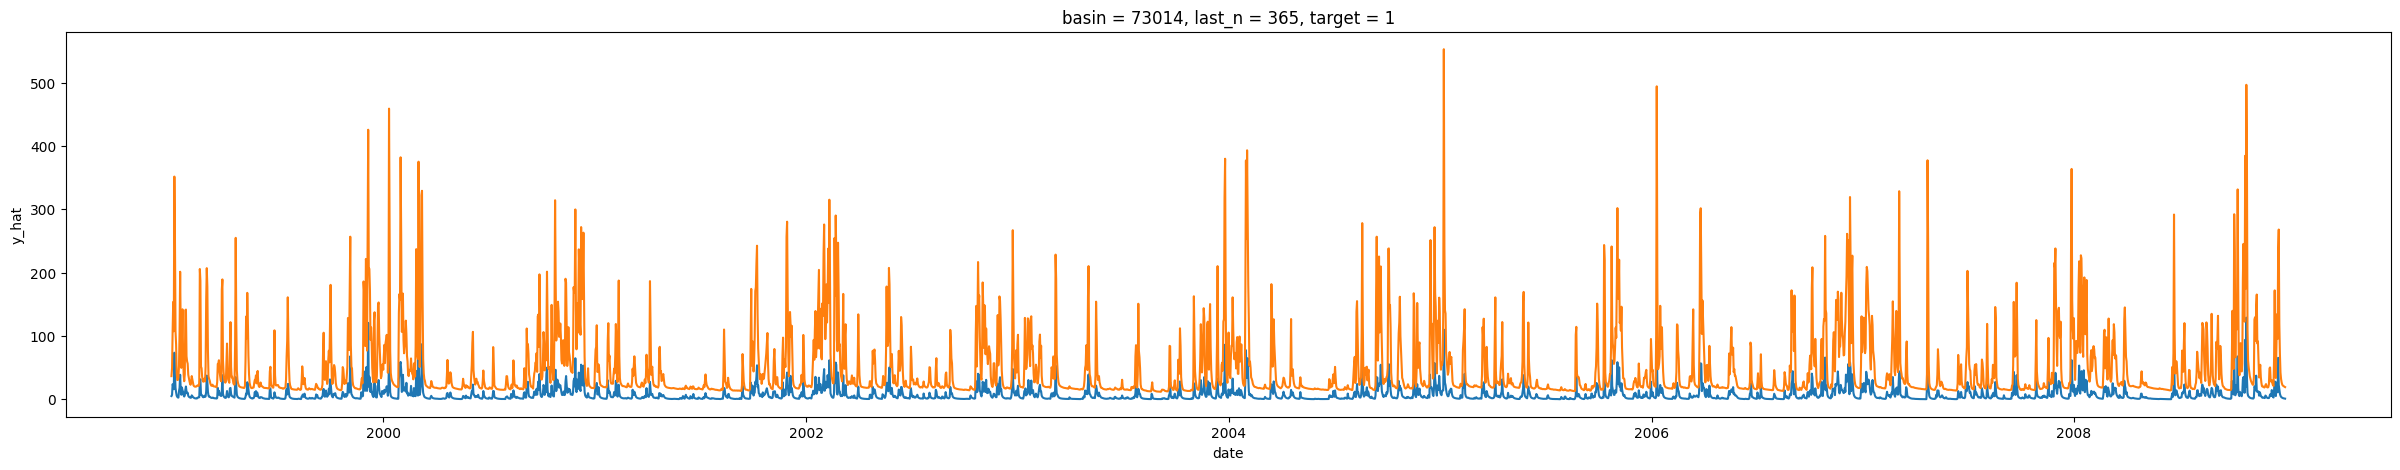

In [10]:
basin_id = "73014"

fig, ax = plt.subplots(figsize=(30, 5))
results.sel(basin=basin_id, last_n=365).y_obs.plot(ax=ax, label="Observed", color="tab:blue")
results.sel(basin=basin_id, last_n=365).y_hat.plot(ax=ax, label="Predicted", color="tab:orange")
plt.show()